In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#export
from nb_004 import *

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10'

data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(data_mean,data_std)

train_tfms = [flip_lr(p=0.5),
              pad(padding=4),
              crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]
valid_tfms = []

bs = 64

## Tweaks to the OptimWrapper to handle an array of lrs/wds/...

We will modify OptimWrapper so that it accepts lists of hyperparameters (learning rate, weight decay, momentum, beta, alpha). We will use this by first defining a set of groups of layers and then defining one hyperparameter value for each group.

An example of this is _Discriminative learning rates_, which consists of using different learning rates on different layers during training.

In [27]:
#export
ModuleList = Collection[nn.Module]
ParamList = Collection[nn.Parameter]

bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

def requires_grad(l:nn.Module, b:Optional[bool]=None)->Optional[bool]:
    "If b is not set requires_grad on all params in l, else return requires_grad of first param"
    ps = list(l.parameters())
    if not ps: return None
    if b is None: return ps[0].requires_grad
    for p in ps: p.requires_grad=b

def trainable_params(m:nn.Module)->ParamList: 
    "Return list of trainable params in `m`"
    res = filter(lambda p: p.requires_grad, m.parameters())
    return res

def split_bn_bias(layer_groups:ModuleList)->ModuleList:
    "Sort each layer in  `layer_groups` into batchnorm (`bn_types`) and non-batchnorm groups"
    split_groups = []
    for l in layer_groups:
        l1,l2 = [],[]
        for c in l.children():
            if isinstance(c, bn_types): l2.append(c)
            else:                       l1.append(c)
        split_groups += [nn.Sequential(*l1), nn.Sequential(*l2)]
    return split_groups

In [28]:
type(optim.SGD)

type

In [32]:
#export
class OptimWrapper():
    "Basic wrapper around an optimizer to simplify HP changes"
    def __init__(self, opt:optim.Optimizer, wd:Floats=0., true_wd:bool=False, bn_wd:bool=True)->None:
        self.opt,self.true_wd,self.bn_wd = opt,true_wd,bn_wd
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
        self.wd = wd
        
    @classmethod
    def create(cls, opt_fn:Union[type,Callable], lr:Union[float,Tuple,List], 
               layer_groups:ModuleList, **kwargs:Any)->optim.Optimizer:
        "Create an optim.Optimizer from `opt_fn` with `lr`. Set lr on `layer_groups``"
        split_groups = split_bn_bias(layer_groups)
        print('opt_fn:', opt_fn)
        print('len(split_groups):', len(split_groups))
        opt = opt_fn([{'params': trainable_params(l), 'lr':0} for l in split_groups])
        opt = cls(opt, **kwargs)
        opt.lr = listify(lr, layer_groups)
        return opt
    
    def __repr__(self)->str:
        return f'OptimWrapper over {repr(self.opt)}.\nTrue weight decay: {self.true_wd}'

    #Pytorch optimizer methods
    def step(self)->None:
        "Set weight decay and step optimizer"
        # weight decay outside of optimizer step (AdamW)
        if self.true_wd:
            for lr,wd,pg1,pg2 in zip(self._lr,self._wd,self.opt.param_groups[::2],self.opt.param_groups[1::2]):
                for p in pg1['params']: p.data.mul_(1 - wd*lr)
                if self.bn_wd:
                    for p in pg2['params']: p.data.mul_(1 - wd*lr)
            self.set_val('weight_decay', listify(0, self._wd))
        self.opt.step()
    
    def zero_grad(self)->None: 
        "Clear optimizer gradients"
        self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self)->float: 
        "Get learning rate"
        return self._lr[-1]

    @lr.setter
    def lr(self, val:float)->None: 
        "Set learning rate"
        self._lr = self.set_val('lr', listify(val, self._lr))
    
    @property
    def mom(self)->float: 
        "Get momentum"
        return self._mom[-1]

    @mom.setter
    def mom(self, val:float)->None:
        "Set momentum"
        if 'momentum' in self.opt_keys: self.set_val('momentum', listify(val, self._mom))
        elif 'betas' in self.opt_keys:  self.set_val('betas', (listify(val, self._mom), self._beta))
        self._mom = listify(val, self._mom)
    
    @property
    def beta(self)->float: 
        "get beta"
        return None if self._beta is None else self._beta[-1]

    @beta.setter
    def beta(self, val:float)->None:
        "Set beta (or alpha as makes sense for give optimizer)"
        if val is None: return
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom, listify(val, self._beta)))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', listify(val, self._beta))
        self._beta = listify(val, self._beta)
    
    @property
    def wd(self)->float: 
        "Get weight decay"
        return self._wd[-1]

    @wd.setter
    def wd(self, val:float)->None:
        "Set weight decay"
        if not self.true_wd: self.set_val('weight_decay', listify(val, self._wd), bn_groups=self.bn_wd)
        self._wd = listify(val, self._wd)
    
    #Helper functions
    def read_defaults(self)->None:
        "Read the values inside the optimizer for the hyper-parameters"
        self._beta = None
        if 'lr' in self.opt_keys: self._lr = self.read_val('lr')
        if 'momentum' in self.opt_keys: self._mom = self.read_val('momentum')
        if 'alpha' in self.opt_keys: self._beta = self.read_val('alpha')
        if 'betas' in self.opt_keys: self._mom,self._beta = self.read_val('betas')
        if 'weight_decay' in self.opt_keys: self._wd = self.read_val('weight_decay')
    
    def set_val(self, key:str, val:Any, bn_groups:bool=True)->Any:
        "Set the values inside the optimizer dictionary at the key"
        if is_tuple(val): val = [(v1,v2) for v1,v2 in zip(*val)]
        #[::2] for non-bn layers, [1::2] for bn layers
        for v,pg1,pg2 in zip(val,self.opt.param_groups[::2],self.opt.param_groups[1::2]): 
            pg1[key] = v
            if bn_groups: pg2[key] = v
        return val
    
    def read_val(self, key:str) -> Union[List[float],Tuple[List[float],List[float]]]:
        "Read a hyper-parameter key in the optimizer dictionary."
        val = [pg[key] for pg in self.opt.param_groups[::2]]
        if is_tuple(val[0]): val = [o[0] for o in val], [o[1] for o in val]
        return val

In [33]:
listify

<function nb_002.listify(p: Union[Collection[Any], int, float, str, NoneType] = None, q: Union[Collection[Any], int, float, str, NoneType] = None)>

In [34]:
??listify

In [57]:
#export
def children(m:nn.Module)->ModuleList: 
    "Get children of module"
    return list(m.children())
def num_children(m:nn.Module)->int: 
    "Get number of child modules in module"
    return len(children(m))
def range_children(m:nn.Module)->Iterator[int]: 
    "Return iterator of len of children of m"
    return range(num_children(m))

flatten_model=lambda l: sum(map(flatten_model,l.children()),[]) if num_children(l) else [l]
def first_layer(m:nn.Module)->nn.Module:
    "Retrieve first layer in a module"
    return flatten_model(m)[0]

def split_model_idx(model:nn.Module, idxs:Collection[int])->ModuleList:
    "Split the model according to the indices in [idxs]"
    layers = flatten_model(model)
    if idxs[0] != 0: idxs = [0] + idxs
    if idxs[-1] != len(layers): idxs.append(len(layers))
    return [nn.Sequential(*layers[i:j]) for i,j in zip(idxs[:-1],idxs[1:])]

def split_model(model:nn.Module, splits:Collection[ModuleList], want_idxs:bool=False):
    "Split the model according to the layers in [splits]"
    layers = flatten_model(model)
    idxs = [layers.index(first_layer(s)) for s in listify(splits)]
    res = split_model_idx(model, idxs)
    return (res,idxs) if want_idxs else res

We will now try our Wrapper with the Darknet neural net architecture.

In [58]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)

We are now going to split the model in layers so that we can try our OptimWrapper with more than one value per hyperparameter. In particular, we are going to split the 18 layers in the model into three groups: 0-5, 6-9 and 10-18. Afterwards, when setting the value for our hyperparameters, we will need to define a different value for each of these groups.

In [59]:
splits = [model.layers[9], model.layers[15]]
layer_groups,idxs = split_model(model, splits, want_idxs=True)
lrs = np.array([1e-3,1e-2,0.1])
tst_opt = OptimWrapper.create(optim.SGD, lrs, layer_groups, bn_wd=False)
idxs

opt_fn: <class 'torch.optim.sgd.SGD'>
len(split_groups): 6


[42, 72]

non-bn groups

In [60]:
len(tst_opt.opt.param_groups), len(tst_opt.opt.param_groups[::2])

(6, 3)

In [61]:
tst_opt.opt.param_groups[0]==tst_opt.opt.param_groups[::2][0]

True

In [62]:
tst_opt.opt.param_groups[2]==tst_opt.opt.param_groups[::2][1]

True

In [63]:
tst_opt.opt.param_groups[4]==tst_opt.opt.param_groups[::2][2]

True

bn groups

In [64]:
len(tst_opt.opt.param_groups), len(tst_opt.opt.param_groups[1::2])

(6, 3)

In [65]:
tst_opt.opt.param_groups[1]==tst_opt.opt.param_groups[1::2][0]

True

In [66]:
tst_opt.opt.param_groups[3]==tst_opt.opt.param_groups[1::2][1]

True

In [67]:
tst_opt.opt.param_groups[5]==tst_opt.opt.param_groups[1::2][2]

True

In [68]:
tst_opt.opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0.0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0.0

Parameter Group 3
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 4
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0.0

Parameter Group 5
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [69]:
len(layer_groups)

3

In [70]:
len(tst_opt.opt.param_groups), tst_opt.opt.param_groups[0]['weight_decay']

(6, 0.0)

In [71]:
[o.keys() for o in tst_opt.opt.param_groups]

[dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov']),
 dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov']),
 dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov']),
 dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov']),
 dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov']),
 dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])]

In [72]:
[o['lr'] for o in tst_opt.opt.param_groups]

[0.001, 0.001, 0.01, 0.01, 0.1, 0.1]

In [73]:
[len(o['params']) for o in tst_opt.opt.param_groups]

[14, 28, 10, 20, 2, 0]

In [74]:
tst_opt.opt.param_groups[0]['lr'],tst_opt.opt.param_groups[1]['lr']

(0.001, 0.001)

In [75]:
tst_opt.wd = 1e-2

In [76]:
tst_opt.opt.param_groups[0]['weight_decay'],tst_opt.opt.param_groups[1]['weight_decay']

(0.01, 0)

In [77]:
tst_opt.lr = 1e-2

In [78]:
tst_opt.opt.param_groups[0]['lr'],tst_opt.opt.param_groups[1]['lr']

(0.01, 0.01)

We can set the hyperparameters in two ways:

1. optimizer_object.\_hyperparameter = [val1, val2 ..., valn] (n = number of layer groups)

2. optimizer_object.hyperparameter = val

If we chose to set it in way 1, we must specify a number of values exactly equal to the number of layer groups. If we chose to set it in way 2, the chosen value will be repeated for all layer groups.

In [79]:
tst_opt.lr, tst_opt._lr

(0.01, [0.01, 0.01, 0.01])

In [80]:
tst_opt.wd, tst_opt._wd

(0.01, [0.01, 0.01, 0.01])

In [81]:
# expect exception
# tst_opt.wd = [0.1,0.1]

In [82]:
# expect exception
# tst_opt.lr = [0.1,0.1]

## Now let's tweak the learner to handle this.

We have added some important functions into the Learner class. We have built *create_opt* that creates the optimizer with the wrapper, _split_ that splits our model into layer groups, *freeze_to*, _freeze_ and _unfreeze_ that allow us to freeze and unfreeze parts of the network or even the whole network.

Add gradient clipping at this stage in a callback.

In [83]:
#export
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

def set_bn_eval(m:nn.Module)->None:
    "Set bn layers in eval mode for all recursive children of m"
    for l in m.children():
        if isinstance(l, bn_types) and not next(l.parameters()).requires_grad:
            l.eval()
        set_bn_eval(l)

@dataclass
class BnFreeze(Callback):
    "Set all bntypes layers in `learn` to eval() on_epoch_begin"
    learn:Learner
    def on_epoch_begin(self, **kwargs:Any)->None: 
        "Put bn layers in eval mode on epoch_begin"
        set_bn_eval(self.learn.model)

def even_mults(start:float, stop:float, n:int)->np.ndarray:
    "Build evenly stepped schedule from start to stop in n steps"
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])

default_lr = slice(3e-3)
default_wd = 1e-2

In [91]:
even_mults(1e-2, 1e-5, 4)

array([1.e-02, 1.e-03, 1.e-04, 1.e-05])

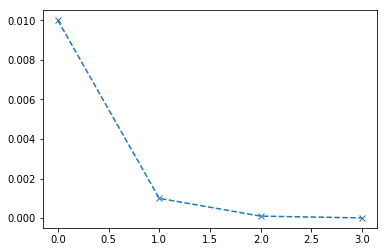

In [94]:
plt.plot(even_mults(1e-2, 1e-5, 4), 'x--')

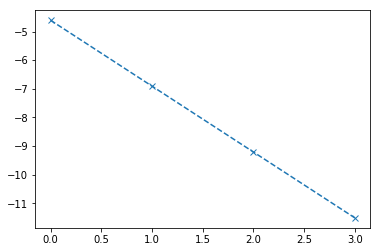

In [95]:
plt.plot(np.log(even_mults(1e-2, 1e-5, 4)), 'x--')

In [96]:
#export

SplitFuncOrIdxList = Union[Callable, Collection[ModuleList]]
@dataclass
class Learner():
    "Object that wraps together some data, a model, a loss function and an optimizer"
    data:DataBunch
    model:nn.Module
    opt_fn:Callable=AdamW
    loss_fn:Callable=F.cross_entropy
    metrics:Collection[Callable]=None
    true_wd:bool=True
    bn_wd:bool=True
    wd:Floats=default_wd
    train_bn:bool=True
    path:str = None
    model_dir:str = 'models'
    callback_fns:Collection[Callable]=None
    callbacks:Collection[Callback]=field(default_factory=list)
    layer_groups:Collection[nn.Module]=None
    def __post_init__(self)->None:
        "Setup path,metrics, callbacks and ensure model directory exists"
        self.path = Path(ifnone(self.path, self.data.path))
        (self.path/self.model_dir).mkdir(parents=True, exist_ok=True)
        self.model = self.model.to(self.data.device)
        self.metrics=listify(self.metrics)
        if not self.layer_groups: self.layer_groups = [nn.Sequential(*flatten_model(self.model))]
        self.callbacks = listify(self.callbacks)
        self.callback_fns = [Recorder] + listify(self.callback_fns)

    def lr_range(self, lr:Union[float,slice])->np.ndarray:
        "Build learning rate schedule"
        if not isinstance(lr,slice): return lr
        if lr.start: res = even_mults(lr.start, lr.stop, len(self.layer_groups))
        else: res = [lr.stop/3]*(len(self.layer_groups)-1) + [lr.stop]
        return np.array(res)
        
    def fit(self, epochs:int, lr:Union[Floats,slice]=default_lr, 
            wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`"
        lr = self.lr_range(lr)
        if wd is None: wd = self.wd
        self.create_opt(lr, wd)
        callbacks = [cb(self) for cb in self.callback_fns] + listify(callbacks)
        fit(epochs, self.model, self.loss_fn, opt=self.opt, data=self.data, metrics=self.metrics,
            callbacks=self.callbacks+callbacks)

    def create_opt(self, lr:Floats, wd:Floats=0.)->None:
        "create optimizer with `lr` learning rate and `wd` weight decay"
        self.opt = OptimWrapper.create(self.opt_fn, lr, self.layer_groups, wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
        
    def split(self, split_on:SplitFuncOrIdxList)->None:
        "split the model at `split_on`"
        if isinstance(split_on,Callable): self.layer_groups = split_on(self.model)
        else: self.layer_groups = split_model(self.model, split_on)

    def freeze_to(self, n:int)->None:
        "freeze layers up to layer `n`"
        for g in self.layer_groups[:n]:
            for l in g:
                if not self.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        for g in self.layer_groups[n:]: requires_grad(g, True)

    def freeze(self)->None:
        "freeze up to last layer"
        assert(len(self.layer_groups)>1)
        self.freeze_to(-1)
        
    def unfreeze(self): 
        "unfreeze entire model"
        self.freeze_to(0)
    def __del__(self): del(self.model, self.data)        
    def save(self, name:PathOrStr): 
        "save model with `name` to `self.model_dir`"
        torch.save(self.model.state_dict(), self.path/self.model_dir/f'{name}.pth')
    def load(self, name:PathOrStr): 
        "load model `name` from `self.model_dir"
        self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth'))

In [97]:
#export
def fit_one_cycle(learn:Learner, cyc_len:int,
                  max_lr:Union[Floats,slice]=default_lr, moms:Tuple[float,float]=(0.95,0.85),
                  div_factor:float=25., pct_start:float=0.3, wd:float=None, **kwargs)->None:
    "Fits a model following the 1cycle policy"
    max_lr = learn.lr_range(max_lr)
    cbs = [OneCycleScheduler(learn, max_lr, moms=moms, div_factor=div_factor,
                             pct_start=pct_start, **kwargs)]
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=cbs)

Learner.fit_one_cycle = fit_one_cycle
Learner.lr_find = lr_find

In [98]:
train_ds = ImageDataset.from_folder(PATH/'train', classes=['airplane','dog'])
valid_ds = ImageDataset.from_folder(PATH/'test', classes=['airplane','dog'])
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=train_tfms, valid_tfm=valid_tfms, dl_tfms=cifar_norm)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [99]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, true_wd=True)
learn.metrics = [accuracy]
learn.split((model.layers[9],model.layers[15]))
learn.freeze()

In [100]:
l1,l2 = model.layers[0],model.layers[-1]; l1,l2

(Sequential(
   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): LeakyReLU(negative_slope=0.1, inplace)
 ), Linear(in_features=512, out_features=2, bias=True))

In [101]:
requires_grad(l1[0]),requires_grad(l1[1]),requires_grad(l2)

(False, True, True)

As we know, setting a hyperparameter to a list of length different from the number of layer groups will return an error.

In [102]:
# expect exception
# learn.fit(1, [0.1,0.1], wd=1e-2)

In [103]:
learn.fit_one_cycle(1, slice(1e-1))

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:09
epoch  train loss  valid loss  accuracy
0      0.328749    0.252526    0.904000  (00:09)



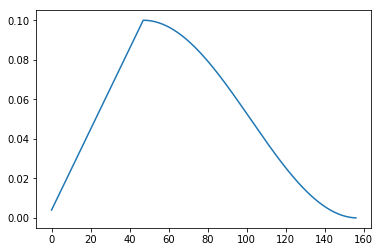

In [104]:
learn.recorder.plot_lr()

In [105]:
learn.fit(1, 1e-1, wd=1e-2)

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:08
epoch  train loss  valid loss  accuracy
0      0.353332    0.283910    0.900500  (00:08)



In [106]:
learn.opt._lr

[0.1, 0.1, 0.1]

In [107]:
learn.fit(1, slice(1e-3,1e-1), wd=1e-2)

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:08
epoch  train loss  valid loss  accuracy
0      0.286403    0.241571    0.903500  (00:08)



In [108]:
learn.opt._lr

[0.001, 0.01, 0.1]

In [109]:
learn.unfreeze()

In [110]:
requires_grad(l1[0]),requires_grad(l1[1]),requires_grad(l2)

(True, True, True)

In [111]:
learn.fit(1, lrs, wd=1e-2)

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:11
epoch  train loss  valid loss  accuracy
0      0.249659    0.196264    0.924000  (00:11)



In [112]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
learn.metrics = [accuracy]

In [113]:
learn.fit(1,0.1)

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 2


Total time: 00:11
epoch  train loss  valid loss  accuracy
0      0.510917    0.406081    0.853000  (00:11)



In [114]:
learn.opt._lr

[0.1]

In [115]:
def darknet_split(m) : return split_model(m,[m.layers[9],m.layers[15]])

In [116]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics=[accuracy])
learn.split(darknet_split)

In [117]:
len(learn.layer_groups)

3

In [118]:
learn.fit(1, lrs, wd=[1e-4,1e-3,1e-2])

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:11
epoch  train loss  valid loss  accuracy
0      0.545637    0.322463    0.870500  (00:11)



In [119]:
learn.opt._wd

[0.0001, 0.001, 0.01]

In [120]:
# exception expected
# learn.fit(1, lrs, wd=[1e-4,1e-3])

LRs and WDs are the easiest to pass through the Learner, but if a Callback sets an array of moms or betas, the OptimWrapper will handle them as discriminative moms/betas.

## See how it fits with the other callbacks

In [121]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics = [accuracy])
learn.split(darknet_split)

In [122]:
lr_find(learn, start_lr=lrs/1000, end_lr=lrs*100)

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


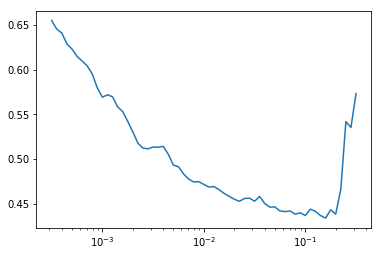

In [123]:
learn.recorder.plot()

In [124]:
sched = OneCycleScheduler(learn, lrs)
learn.fit(1, lrs, callbacks=[sched])

opt_fn: functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))
len(split_groups): 6


Total time: 00:11
epoch  train loss  valid loss  accuracy
0      0.580655    0.326086    0.888500  (00:11)

